In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [2]:
def cluster_variance(n, x):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
    return variances,K,n

In [3]:
ds = xr.open_dataset(f"challenge_1min_numerical.nc")

ds = ds.where((ds.latitude > 0) & (ds.latitude < 20) & (ds.longitude > 100) & (ds.longitude < 160), drop=True)


sh: 1: getfattr: not found


In [4]:
x = ds.drop_vars(['latitude','longitude']).to_array().transpose("time", "variable").values
# x = ds.to_array().transpose("time", "variable").values

x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
x

array([[0.53095238, 0.2464426 , 0.19518217, 0.        ],
       [1.        , 0.29159342, 0.69359671, 0.        ],
       [0.3547619 , 0.41759705, 0.20801349, 0.        ],
       ...,
       [0.        , 0.1293373 , 0.16692285, 0.        ],
       [0.        , 0.23213042, 0.10971402, 0.        ],
       [0.14761905, 0.03141278, 0.23120802, 0.        ]], shape=(1414, 4))

Initialization complete
Iteration 0, inertia 157.0788426050034.
Iteration 1, inertia 109.53618856052422.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 123.36030364695449.
Iteration 1, inertia 85.56706669530004.
Iteration 2, inertia 78.69139130677083.
Iteration 3, inertia 74.68798051834077.
Iteration 4, inertia 72.78137931880228.
Iteration 5, inertia 69.57106182490071.
Iteration 6, inertia 64.760156903152.
Iteration 7, inertia 61.293216530266875.
Iteration 8, inertia 60.96215423862505.
Iteration 9, inertia 60.91795550948879.
Iteration 10, inertia 60.91638417743352.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 62.646374032890556.
Iteration 1, inertia 45.70749714052708.
Iteration 2, inertia 42.94134804843095.
Iteration 3, inertia 42.22737818911902.
Iteration 4, inertia 41.968435955036924.
Iteration 5, inertia 41.88986152748556.
Iteration 6, inertia 41.84013015116222.
Iteration 7, inertia 41.8290275

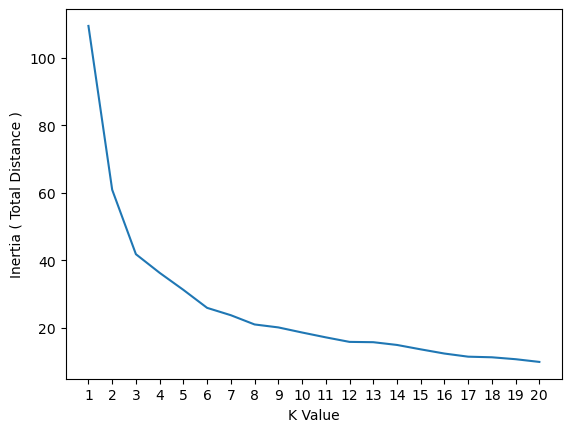

In [5]:
variances,K,n=cluster_variance(20, x)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()

In [6]:
ds

<xarray.Dataset> Size: 62kB
Dimensions:                          (time: 1414)
Coordinates:
  * time                             (time) datetime64[ns] 11kB 2025-06-12T06...
Data variables:
    latitude                         (time) float64 11kB 16.59 12.7 ... 17.03
    longitude                        (time) float64 11kB 107.4 106.7 ... 110.3
    land_flag                        (time) float64 11kB 0.531 1.0 ... 0.1476
    ice_water_path                   (time) float32 6kB 0.5041 ... 0.06425
    liquid_water_path                (time) float32 6kB 0.1489 0.529 ... 0.1763
    aerosol_optical_thickness_355nm  (time) float32 6kB 0.0 0.0 0.0 ... 0.0 0.0

In [7]:
k = 5

# Applichiamo K-Means
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(x)


In [8]:
vars = {
    # 'lat': 0,
    # 'lon': 1,
    'landf' : 0 ,
    'iwp': 1,
    'lwp': 2,
    'aot': 3
}

In [9]:
def plot_kmeans(x, varX, varY, ax=None):

    if not ax:
        fig, ax = plt.subplots()
    
    # Visualizziamo i dati colorati in base ai cluster trovati
    ax.scatter(x[:, vars[varX]], x[:, vars[varY]], c=y_kmeans, s=10, cmap='jet', alpha=0.5)  #'viridis')
    
    # Mostriamo anche i centroidi
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, vars[varX]], centers[:,  vars[varY]], c='red', s=50, alpha=0.75, marker='X', label='Centroids')
    for i in np.arange(1,6):
        ax.text(centers[(i-1), vars[varX]]*1.1, centers[(i-1),  vars[varY]]*1.1, s=str(i), c='red')
    
    ax.set_title("K-Means clustering")
    ax.set_xlabel(varX)
    ax.set_ylabel(varY)
    ax.legend()


In [10]:
[str(i) for i in np.arange(1,6)]

['1', '2', '3', '4', '5']

In [11]:
kmeans.cluster_centers_

array([[0.0069161 , 0.03857716, 0.11220027, 0.23004933],
       [0.00472097, 0.02192577, 0.04161706, 0.01791887],
       [0.86636432, 0.12261765, 0.24921988, 0.05690596],
       [0.35066445, 0.07906242, 0.18360387, 0.02397637],
       [0.01589122, 0.32208783, 0.17482195, 0.01456317]])

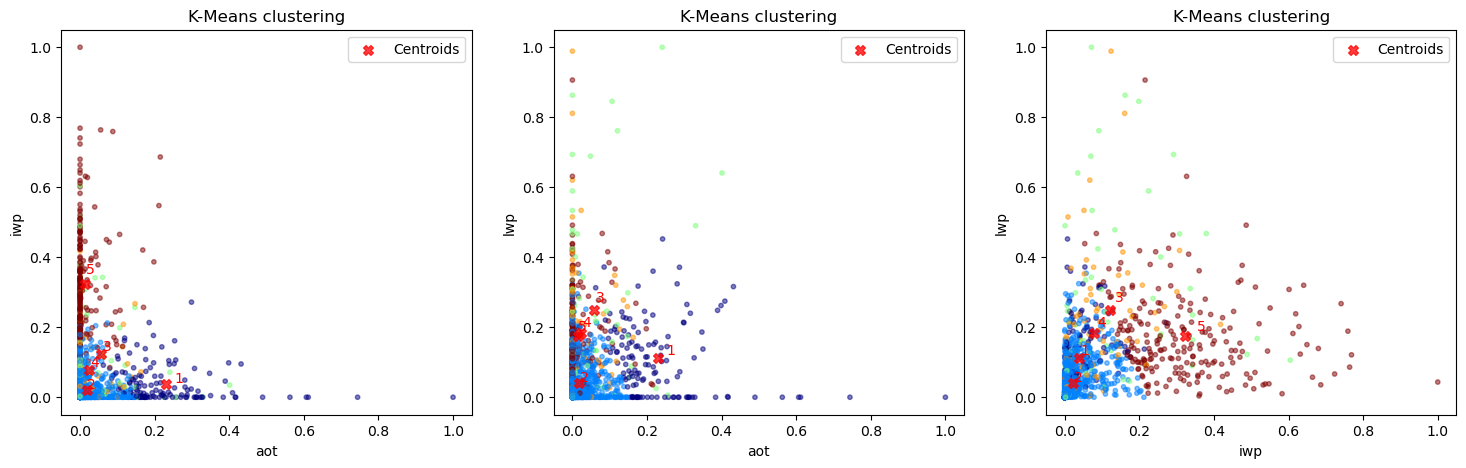

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY, ax=axes[0])

varX='aot'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[1])


varX='iwp'
varY='lwp'

plot_kmeans(x, varX, varY, ax=axes[2])

(0.0, 0.25)

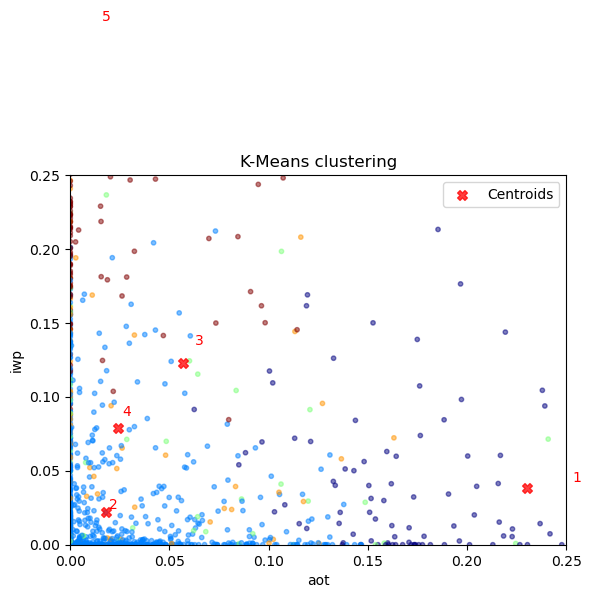

In [13]:
varX='aot'
varY='iwp'

plot_kmeans(x, varX, varY)
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

### Classes we were expepcting:

- Cluster 4: Aerosol with no clouds

- Cluster 3: Ice and water with no transparency (ATLID is not seeing aerosol)

Let's see the other three


In [14]:
# select only clusters 1, 2 and 5

In [15]:
np.unique(y_kmeans)

array([0, 1, 2, 3, 4], dtype=int32)

In [16]:
indices = np.where((y_kmeans == 0) | (y_kmeans == 1) | (y_kmeans == 4))[0]

In [17]:
(vars['iwp'], vars['aot'])

(1, 3)

In [18]:
a = x[indices, 3]
b = x[indices, 1]

m, q = np.polyfit(a, b, deg=1)

b_pred = q + m * a #+ n *a**2

print(q, m, n)


0.08123811252895702 -0.15404956192872538 20


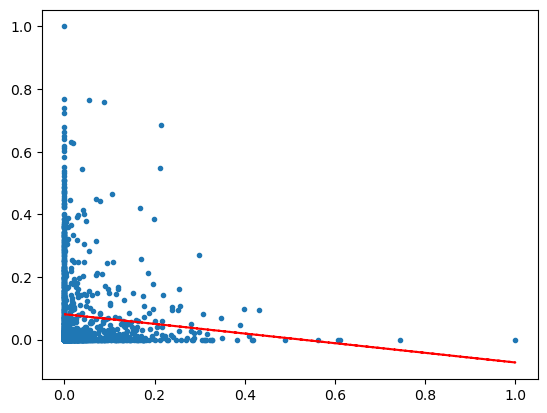

In [19]:
varX='aot'
varY='iwp'

# plot_kmeans(x, varX, varY)
# plt.xlim(0, 0.25)
# plt.ylim(0, 0.25)

plt.plot(a, b, '.')
plt.plot(a, b_pred, 'r--')

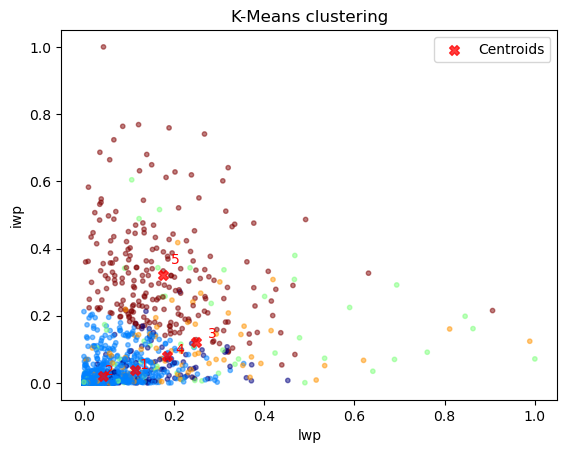

In [20]:
varX='lwp'
varY='iwp'

plot_kmeans(x, varX, varY)

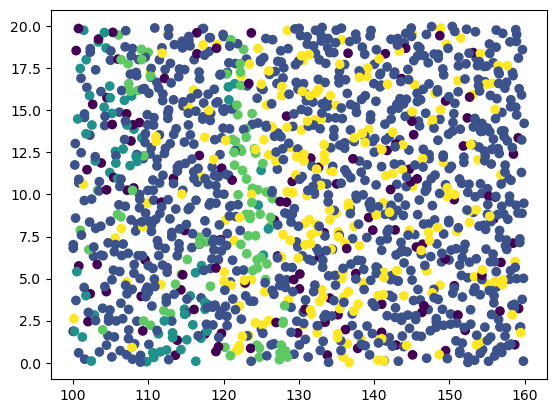

In [21]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='viridis')

Text(0, 0.5, 'latitude')

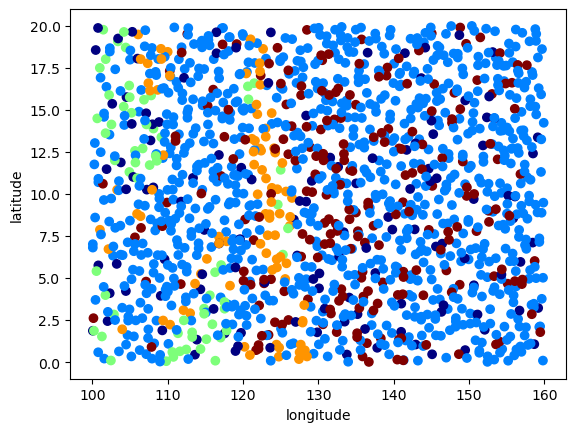

In [22]:
plt.scatter(ds['longitude'].values, ds['latitude'].values, c=y_kmeans, cmap='jet')
plt.xlabel('longitude')
plt.ylabel('latitude')

Add the labels of AC__TC__2B

In [23]:
ds_tc = xr.open_dataset(f"challenge_1min_complete.nc")
ds_tc = ds_tc.where((ds_tc.latitude > 0) & (ds_tc.latitude < 20) & (ds_tc.longitude > 100) & (ds_tc.longitude < 160), drop=True)

ds_tc

sh: 1: getfattr: not found


<xarray.Dataset> Size: 153kB
Dimensions:                          (time: 1414)
Coordinates:
  * time                             (time) datetime64[ns] 11kB 2025-06-12T06...
Data variables: (12/14)
    latitude                         (time) float64 11kB 16.59 12.7 ... 17.03
    longitude                        (time) float64 11kB 107.4 106.7 ... 110.3
    land_flag                        (time) float64 11kB 0.531 1.0 ... 0.1476
    ice_water_path                   (time) float32 6kB 0.5041 ... 0.06425
    liquid_water_path                (time) float32 6kB 0.1489 0.529 ... 0.1763
    aerosol_optical_thickness_355nm  (time) float32 6kB 0.0 0.0 0.0 ... 0.0 0.0
    ...                               ...
    stc_7500                         (time) float64 11kB 7.0 13.0 ... 7.0 1.0
    stc_10000                        (time) float64 11kB 13.0 13.0 ... 13.0 1.0
    stc_12500                        (time) float64 11kB 13.0 14.0 ... 21.0 1.0
    stc_15000                        (time) float64 11kB 21.0 21.0 ... 21.0 21.0
    stc_17500                        (time) float64 11kB 21.0 21.0 ... 1.0 1.0
    stc_20000                        (time) float64 11kB 1.0 1.0 1.0 ... 1.0 1.0

In [29]:
# Synergetic class range and colors
plot_range = range(-1, 35)  # inclusive -1..33
plot_colors = [
    "#c5c9c7", "#a2653e", "#ffffff", "#ff474c", "#0504aa", "#009337",
    "#840000", "#042e60", "#d8dcd6", "#ffff84", "#f5bf03", "#f97306",
    "#ff000d", "#5539cc", "#2976bb", "#0d75f8", "#014182", "#017b92",
    "#06b48b", "#aaff32", "#6dedfd", "#01f9c6", "#7bc8f6", "#d7fffe",
    "#a2cffe", "#04d9ff", "#7a9703", "#b2996e", "#ffbacd", "#d99b82",
    "#947e94", "#856798", "#ac86a8", "#59656d", "#76424e", "#363737"
]

labels = [
    "-1: unknown"," 0: ground"," 1: clear"," 2: possible rain (clutter)"," 3: possible snow (clutter)",
    " 4: possible cloud (clutter)"," 5: heavy rain"," 6: heavy mixed-phase precip",
    " 7: no rain/ice (possible liquid)"," 8: liquid cloud"," 9: drizzling liquid cloud",
    "10: warm rain","11: cold rain","12: melting snow","13: snow (possible liquid)",
    "14: snow (no liquid)","15: rimed snow (possible liquid)",
    "16: rimed snow + supercooled liquid","17: snow + supercooled liquid",
    "18: supercooled liquid","19: ice cloud (possible liquid)",
    "20: ice + supercooled liquid","21: ice cloud (no liquid)",
    "22: stratospheric ice","23: STS (PSC Type I)","24: NAT (PSC Type II)","25: insects",
    "26: dust","27: sea salt","28: continental pollution","29: smoke","30: dusty smoke",
    "31: dusty mix","32: stratospheric ash","33: stratospheric sulfate","34: stratospheric smoke"
]

# Build discrete colormap
cmap = mcolors.ListedColormap(plot_colors)
bounds = list(plot_range) + [34]   # bin edges
norm = mcolors.BoundaryNorm(bounds, cmap.N)# Example: suppose your classification variable is called "target_class"



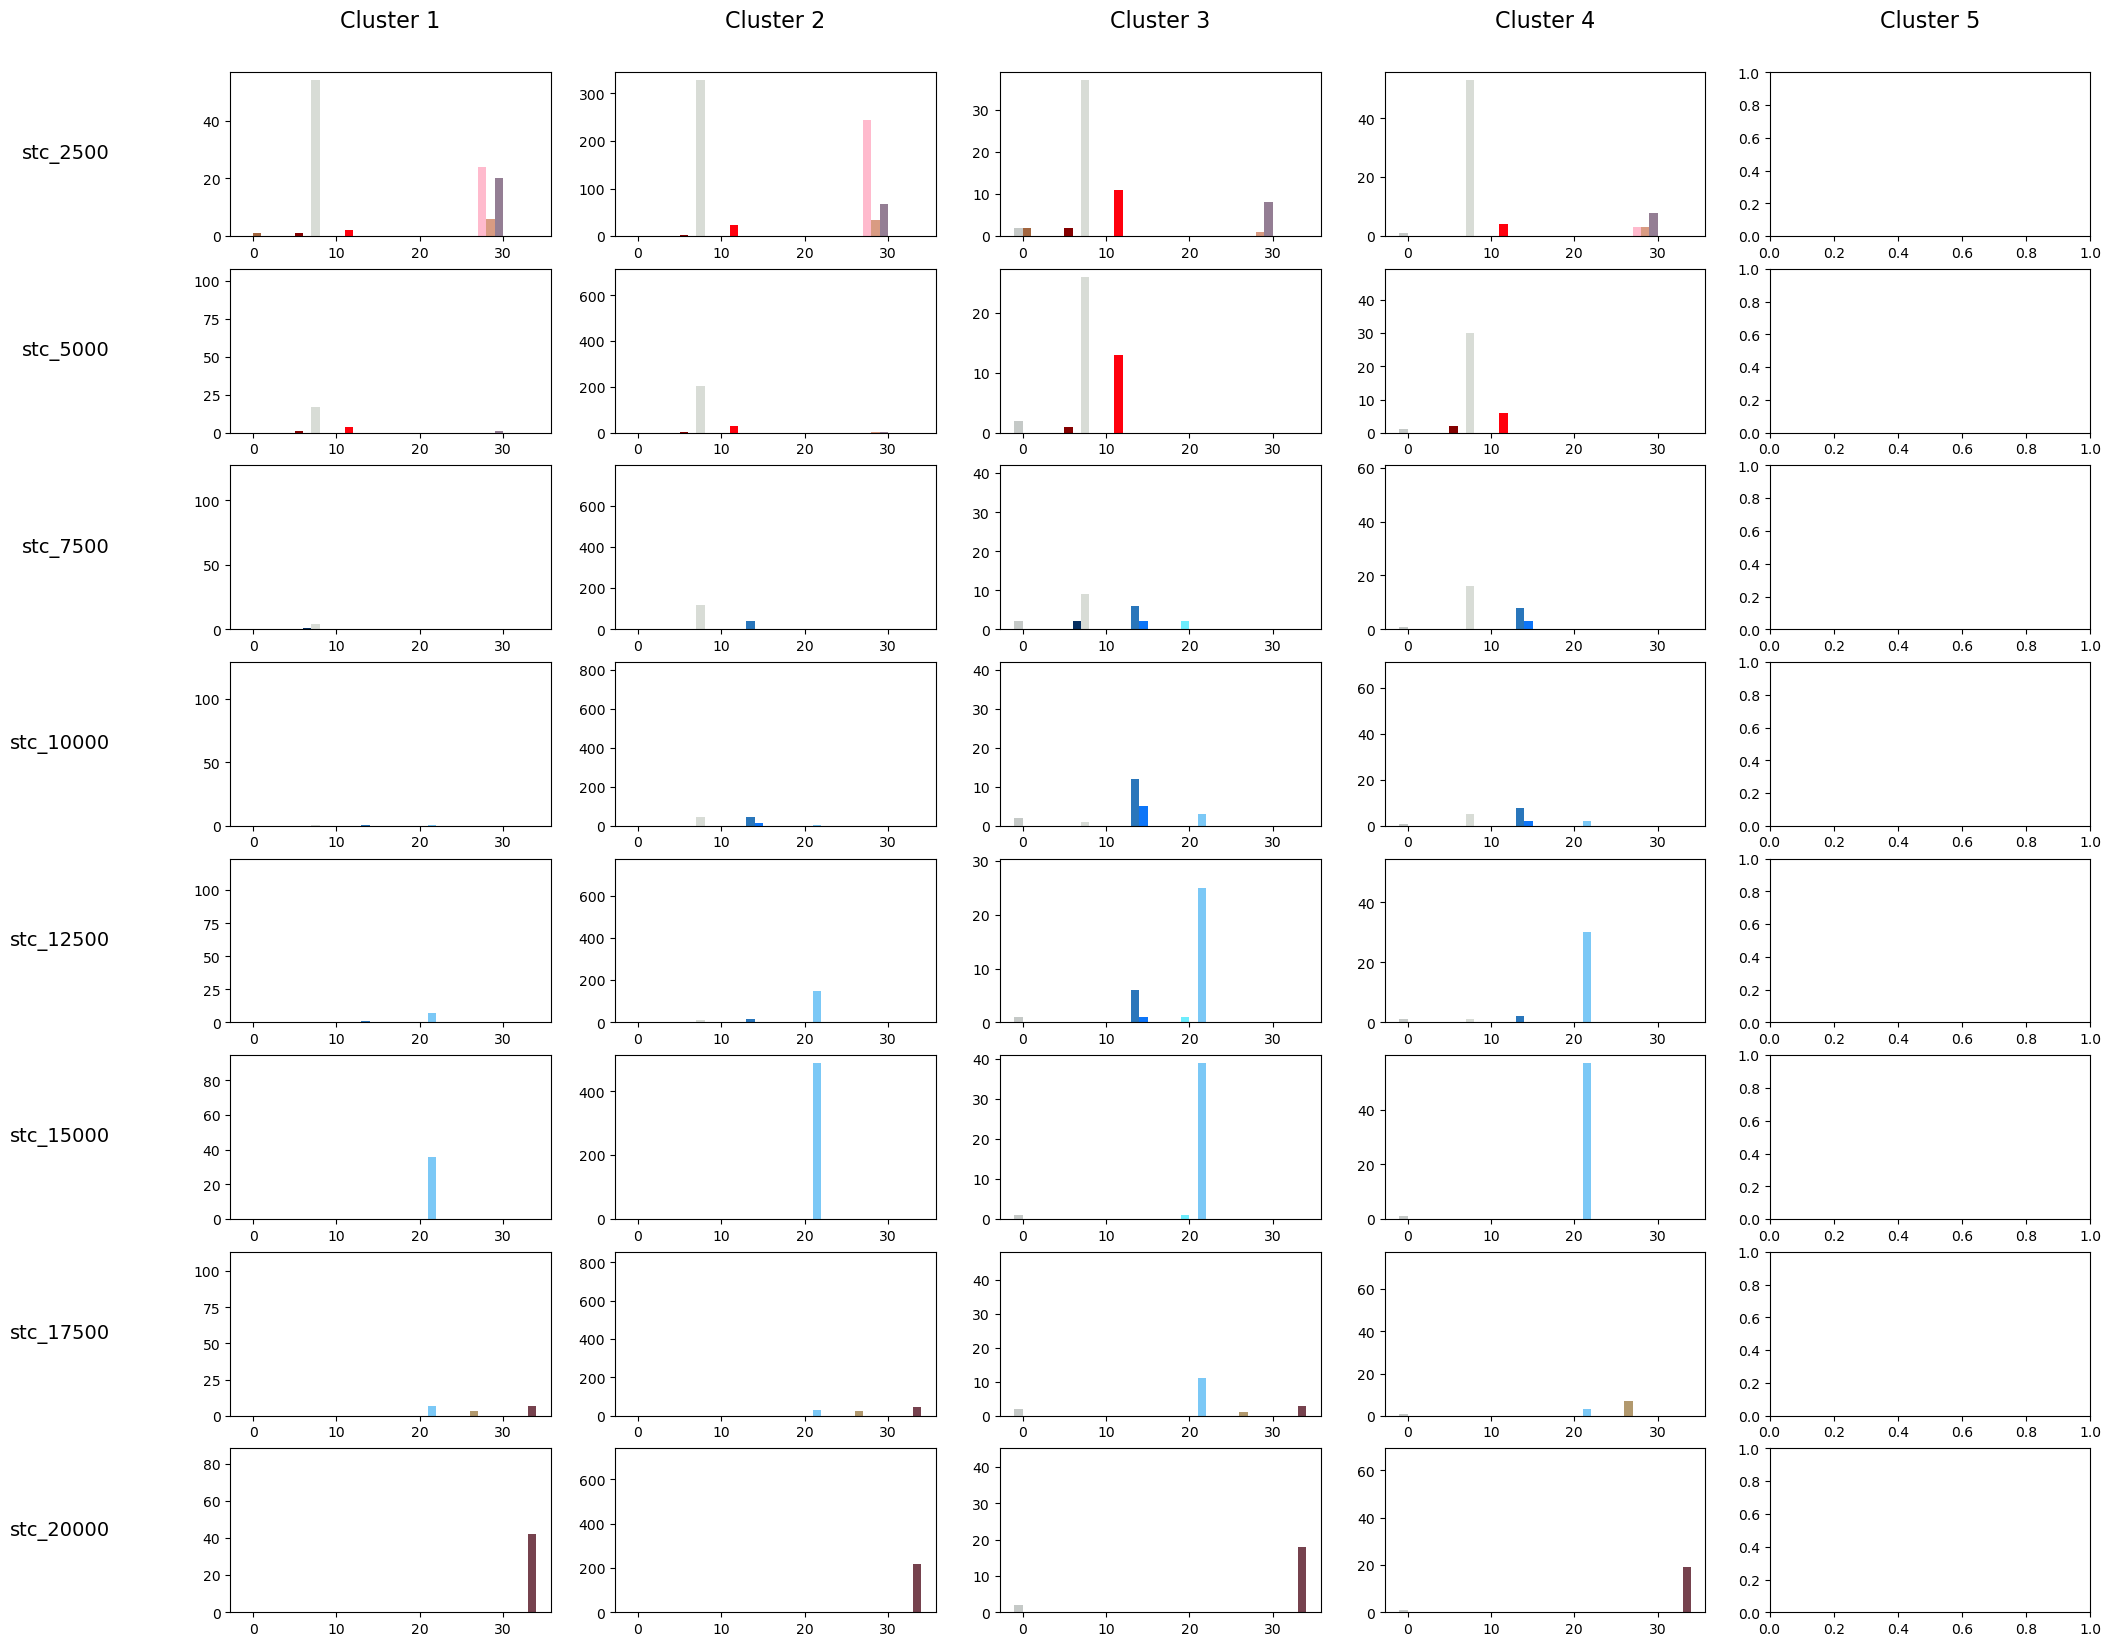

In [42]:
# s = ds_tc["stc_2500"][y_kmeans == 0].plot.hist(bins=bounds)
row_labels = [
    "stc_2500",
    "stc_5000",
    "stc_7500",
    "stc_10000",
    "stc_12500",
    "stc_15000",
    "stc_17500",
    "stc_20000"
]

fig, axes= plt.subplots(8, 5, figsize=(24, 20))

for i, label in enumerate(row_labels): 

    row_axes = axes[i, :]
    # Calcola il centro verticale medio
    y_pos = np.mean([ax.get_position().y0 + ax.get_position().height / 2 for ax in row_axes])
    # Prende la x minima (sinistra)
    x_pos = row_axes[0].get_position().x0 - 0.05
    # Aggiunge il testo
    fig.text(x_pos, y_pos, label, va='center', ha='right', fontsize=14) #, fontweight='bold')
    
    for k in range(4):
        # Crea l'istogramma con 5 bin
        n, bins, patches = axes[i,k].hist(
            ds_tc[label][y_kmeans == k],
            bins=bounds)
        
        for patch, color in zip(patches, plot_colors):
            patch.set_facecolor(color)

col_labels = [
    "Cluster 1",
    "Cluster 2",
    "Cluster 3",
    "Cluster 4",
    "Cluster 5"
]

for j, label in enumerate(col_labels):
    # Prendi gli assi della colonna j
    col_axes = axes[:, j]
    # Calcola la posizione orizzontale centrale della colonna (in figura)
    x0 = min(ax.get_position().x0 for ax in col_axes)
    x1 = max(ax.get_position().x0 + ax.get_position().width for ax in col_axes)
    x_center = (x0 + x1) / 2
    # Calcola la y poco sopra la parte superiore degli assi (usa l’asse superiore)
    top_ax = axes[0, j]
    y_top = top_ax.get_position().y0 + top_ax.get_position().height
    y_text = y_top + 0.02  # spostalo un po’ sopra (modifica questo offset se serve)

    fig.text(x_center, y_text, label, ha='center', va='bottom', fontsize=16) #, fontweight='bold')

